# 05 - Taming Text

In this homework we will explore a relatively large corpus of emails released during the Hillary Clinton email controversy.

Importing useful librairies

In [27]:
import pandas as pd
import numpy as np

import os

from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random

from datetime import datetime

import nltk
from nltk import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk.sentiment.util

import gensim
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from gensim import corpora, models
import itertools

import pycountry
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

# 1. Word Clouds

Reading the csv containing the emails

In [53]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", usecols=['ExtractedSubject','RawText', 'ExtractedBodyText', 'ExtractedFrom'])
emails.head()

ExtractedSubject                             ExtractedFrom  \
0                          FW: Wow  Sullivan, Jacob J <Sullivan11@state.gov>   
1                              NaN                                       NaN   
2                Re: Chris Stevens       Mills, Cheryl D <MillsCD@state.gov>   
3  FVV: Cairo Condemnation - Final       Mills, Cheryl D <MillsCD@state.gov>   
4                              NaN                                       NaN   

                                   ExtractedBodyText  \
0                                                NaN   
1  B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...   
2                                                Thx   
3                                                NaN   
4  H <hrod17@clintonemail.com>\r\nFriday, March 1...   

                                             RawText  
0  UNCLASSIFIED\r\nU.S. Department of State\r\nCa...  
1  UNCLASSIFIED\r\nU.S. Department of State\r\nCa...  
2  UNCLASSIFIED\r\nU.S. Department of State\r\nCa...  
3  UNCLASSIFIED\r\nU.S. Department of State\r\nCa...  
4  B6\r\nUNCLASSIFIED\r\nU.S. Department of State...

Binding all the text from the emails

In [54]:
def createTextFromTokens(text_list):
    text = " ".join(str(x) for x in text_list)
    text = text.replace("\n", " ") 
    return text

In [55]:
print("Percentage of null in field BodyText :", emails.ExtractedBodyText.isnull().sum()/len(emails.ExtractedBodyText), "%")
print("Percentage of null in field RawText :",  emails.RawText.isnull().sum()/len(emails.RawText),  "%")

Percentage of null in field BodyText : 0.151415984896 %
Percentage of null in field RawText : 0.0 %


It could be discussed, but we will use the BodyText field of the data for our analysis, that will be easier to work with then the RawText field, even though it counts more missing fields.

In [56]:
all_text = createTextFromTokens( emails['ExtractedBodyText'].str.lower())

### 1st world cloud, naive
We will simply proceed to create a world cloud following our tokenization of the corpus, without any extra processing.

In [57]:
wc = WordCloud(max_words=1000, mask=None, stopwords=None, margin=10, width = 800, height = 400,
               random_state=1).generate(all_text)

Displaying the World Cloud

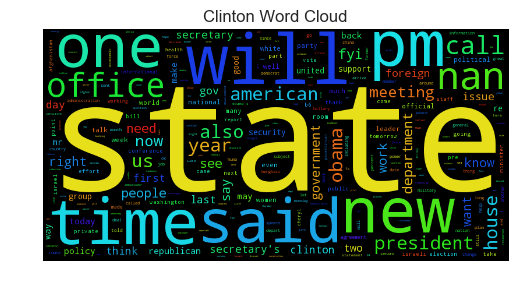

In [61]:
def display_cloud(wc) :
    default_colors = wc.to_array()
    plt.figure()
    plt.title("Clinton Word Cloud")
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()
    return

display_cloud(wc)

As we can see, creating a word cloud without sending the corpus through a well crafted pre-processing pipeline does not yield any useful information...

### 2nd world cloud, refined 


We will first tokenize the text, then remove stopwords using the ntlk stopwords lexicon, plus several that we chose based on the emails.

In [59]:
tokens_raw = nltk.word_tokenize(all_text)


In [60]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('state', 'fyi', 'wa', 'nan', 'ha', 'n\'t', 'sent', 'case', 'gov', 'said', 'original', 'callb6', 'message', 'release', 'department', 'clintonemail', 'pm', 'unclassified', 'date', 'doc', 'subject'))

#### Stemmer vs Lemmatizer
Here we tried to use both the stemmer and lemmatizer. However, it seemed that the lemmatizer makes more sense in this situation, where we want to visualise a word cloud rather than aggregating lexical information to perform a classification. So we chose to use the lemmatizer.


In [62]:
porter = nltk.PorterStemmer()
stemmed = [porter.stem(t) for t in tokens_raw]
wnl = nltk.WordNetLemmatizer()
lemmatized = [wnl.lemmatize(t) for t in tokens_raw]

In [66]:
tokens = [w for w in lemmatized if w.lower() not in stopwords]
print(len(tokens) / len(tokens_raw))

0.626680910251079


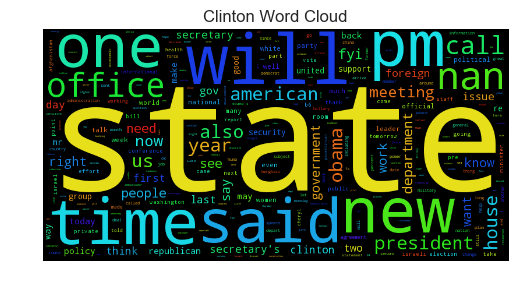

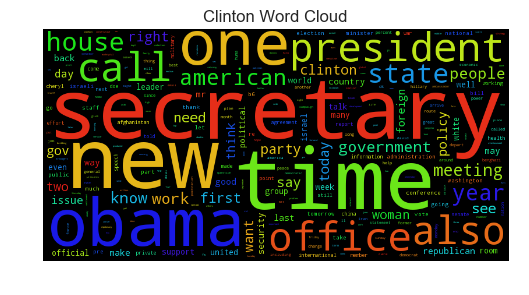

In [67]:
wc_processed = WordCloud(max_words=1000, mask=None, stopwords=None, margin=10,  width = 800, height = 400, 
                         random_state=1).generate(createTextFromTokens(tokens))
display_cloud(wc)
display_cloud(wc_processed)

### Results.
We could skim the corpus some more, but what is appearing through this new word cloud is already interesting : that these **private** emails were indeed relating to her functions as secretary of State, which is forbidden.

# 2. World countries

We will now proceed to find the mentions of world countries in Clinton's emails and, using sentiment analysis methods from the ntlk.util module, associate to each a polarity value describing the general feeling towards said countries, ranging from 1 (positive) to -1 (negative).

To do so, we will start by building a list of every country with data in the pycountry library. 
Then, we will perform sentiment analysis on the email corpus using the Vader method and the Liu Hu opinion lexicon method. As both algorithms are quite demanding in resources, we ran them each once and wrote the output labels to csv files, to be loaded conveniently on necessity.
Finally, we look for mentions of countries in the corpus, and for each that appears, we increment its number of occurences and add the polarity scores in a DataFrame countries_polarity.
We can then present the results.

In [14]:
#Read the corpus fresh, create a list of country codes from pycountry. 
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", usecols=['ExtractedBodyText'])
emails.dropna( subset = ['ExtractedBodyText'], inplace = True)

countries = []
for i in range(0, len(pycountry.countries)) :
    countries.append(list(pycountry.countries)[i].alpha_2)


### VADER method
*A simple rule-based model for general sentiment analysis. A goldstandard list of lexical features (along with their associated sentiment intensity measures) which are specifically attuned
to sentiment in microblog-like contexts, combined with consideration for five general
rules that embody grammatical and syntactical conventions
for expressing and emphasizing sentiment intensity.* 
According to the original paper, VADER outperformsindividual human raters (F1 Classification Accuracy = 0.96 and 0.84, respectively), and generalizes more favorably across contexts than any of their. benchmarks.
[C.J. Hutto & Eric Gilbert 2014](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)


We redefine the VADER method demo instance of ntlk.util by returning the compound value of the analyzer instead of simply printing it, which is of no use (it's originally but a demo method)

In [14]:
#Redefine the Vader method demo instance by returning the compound value of the analyzer instead of printing it
def demo_vader(text):
    """
    Output polarity scores for a text using Vader approach.

    :param text: a text whose polarity has to be evaluated.
    """
    from nltk.sentiment import SentimentIntensityAnalyzer
    vader_analyzer = SentimentIntensityAnalyzer()
    return vader_analyzer.polarity_scores(text)['compound']

We compute the polarity score for each email using the VADER method, allowing us to save the list to a .csv file in order to avoid the computation time in the future.

In [ ]:
vader = []
for email in emails['ExtractedBodyText']:
    vader.append(demo_vader(email.lower()))
    
vader_df = pd.DataFrame(vader, columns=["Vader"])
vader_df.to_csv('vader.csv', index=False)

### Liu Hu Opinion Lexicon method
*This function simply counts the number of positive, negative and neutral words in the sentence and classifies it depending on which polarity is more represented. Words that do not appear in the lexicon are considered as neutral.*
*Hu and Liu, KDD-2004*

We repeat the same process done for the Vader method.

In [59]:
#Redefine the Liu Hu opinion lexicon method demo by returning the label of the classifier
#instead of printing it.
def demo_liuhu(sentence):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    if pos_words > neg_words:
        return 1.0
    elif pos_words < neg_words:
        return -1.0
    elif pos_words == neg_words:
        return 0.0


We compute the polarity score for each mail using the LIU HU Opinion Lexicon method, allowing us to save the list to a .csv to avoid the computation time in the future.

In [ ]:
liuhu = []
for email in emails['ExtractedBodyText']:
    liuhu.append(demo_liuhu(email.lower()))
    
liuhu_df = pd.DataFrame(liuhu, columns=["Liu Hu"])
liuhu_df.to_csv('liuhu.csv', index=False)

### Looking up countries by country codes

If we look up countries by their 2 letters code, a lot of care must be given not to mismatch an english word, acronym or abbreviation capitalized with one such country.
To help avoid this situation, we escape the codes looked up with whitespaces, so that the match cannot append in the middle of a word, and we avoid the common short words mistaken for countries (namely, BY TV TO NO SE PM IN AM FM PR AT AQ)

Looking up 3 letters codes, one must also take care not to aggregate all the occurences of the alpha codes blindly. for instance, the Libyan city Benghazi, which is mentioned often, would be read as BEN + GHA, Benin and Ghana. So we escape again the alpha codes with whitespaces. VAT refers to the VAT Number, etc...

Our parsing is not perfect but overall decent.

In [ ]:
#Exploratory function to visualize the 2 letters alpha_2 codes kept 
for email in emails['ExtractedBodyText']:
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_2 + ' ') in email and list(pycountry.countries)[j].alpha_2 not in 'BY TV TO NO SE PM IN AM FM PR AT PA AQ' :
            print(list(pycountry.countries)[j].alpha_2)

In [ ]:
#Exploratory function to visualize the 3 letters alpha_3 codes kept
for email  in emails['ExtractedBodyText']:
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_3 + ' ') in email and list(pycountry.countries)[j].alpha_3 not in 'AND POL VAT GEO EST' :
            print(list(pycountry.countries)[j].alpha_3)

## Analysis

In [19]:
#Read the sentiment analysis scores for the corpus
vader = pd.read_csv("vader.csv", usecols=['Vader'])['Vader'].values.tolist()
liuhu = pd.read_csv("liuhu.csv", usecols=['Liu Hu'])['Liu Hu'].values.tolist()

#Create a dataframe to hold the records for each country
countries_polarity = pd.DataFrame(countries, columns=['Country'])
countries_polarity['Occurences'] = 0
countries_polarity['Vader'] = 0.0
countries_polarity['Liu Hu'] = 0.0
countries_polarity.set_index("Country", inplace=True)

#Read every mail, search for occurences of countries' 1. full name, 2. alpha_2 3. alpha_3
#and update the datarame accordingly.
for email, i  in zip(emails['ExtractedBodyText'], range(0,len(emails['ExtractedBodyText']))):
    for j in range(0, len(pycountry.countries)) :
        if list(pycountry.countries)[j].name.lower() in email.lower():
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]
                
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_2 + ' ') in email and list(pycountry.countries)[j].alpha_2 not in 'BY TV TO NO SE PM IN AM FM PR  AT PA AQ' :
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]            
                
        if (' ' + list(pycountry.countries)[j].alpha_3 + ' ') in email and list(pycountry.countries)[j].alpha_3 not in 'AND POL VAT GEO EST' :
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]            

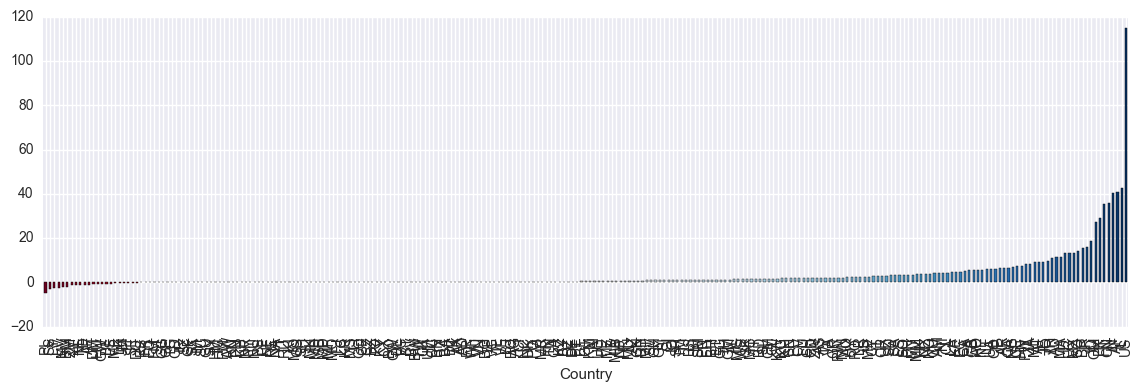

In [113]:
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity))
countries_polarity.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
                

We will make the visualisation more interesting, obviously by discarding the numerous countries which never appeared in the emails, and by averaging the polarity scores to get back to a value comprised between -1 and 1, giving a clearer insight on the countries perception.

The Liu Hu score appears in full colors, whereas the VADER scores appear desaturated. This way, we are able to visualize the discrepancies between both on the same plot already.

C:\Users\Mathieu\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


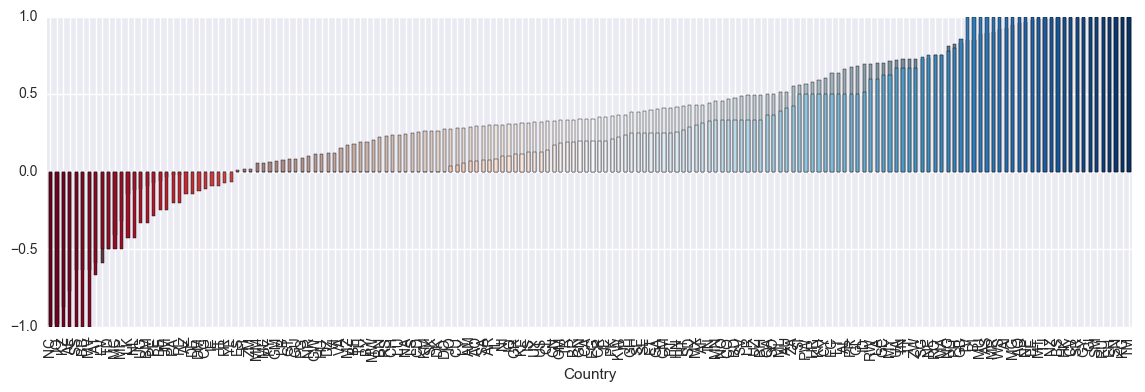

In [20]:
#Delete countries that are never mentioned in Clinton's emails
countries_polarity_plot_normalized = countries_polarity[countries_polarity['Occurences'] > 0]
#Average the polarity
countries_polarity_plot_normalized.Vader = countries_polarity_plot_normalized.Vader.div(countries_polarity_plot_normalized.Occurences, axis='index')
countries_polarity_plot_normalized['Liu Hu'] = countries_polarity_plot_normalized['Liu Hu'].div(countries_polarity_plot_normalized.Occurences, axis='index')
#Plot the polarity
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized), desat=.3)
countries_polarity_plot_normalized.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized))
countries_polarity_plot_normalized.sort_values(by='Liu Hu')['Liu Hu'].plot(kind='bar', figsize=(14,4), color= palette);

Now let's refine the plot even more by discarding the countries mentionned less than 10 times.

46


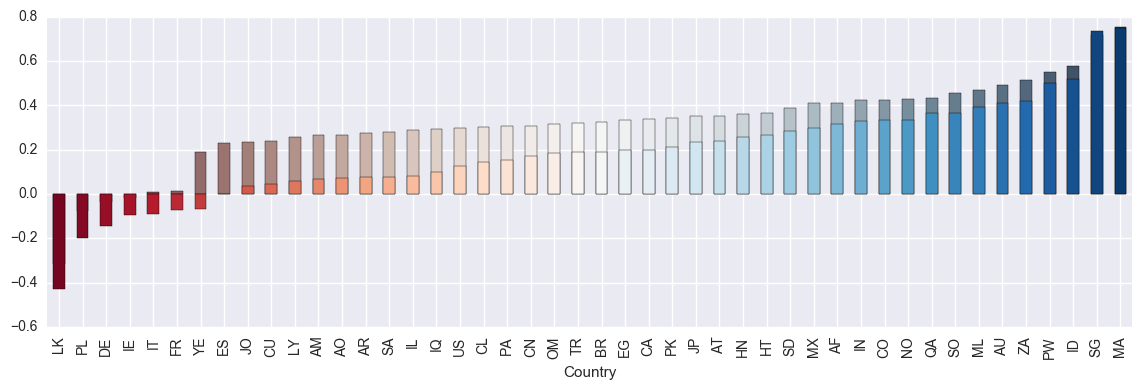

In [111]:
print(len(countries_polarity[countries_polarity['Occurences'] > 10]))
countries_polarity_plot_normalized = countries_polarity_plot_normalized[countries_polarity_plot_normalized['Occurences'] > 10]
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized), desat=.3)
countries_polarity_plot_normalized.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized))
countries_polarity_plot_normalized.sort_values(by='Liu Hu')['Liu Hu'].plot(kind='bar', figsize=(14,4), color= palette);

## Results

We see that there is indeed a substantial difference in the results given by the two methods, especially in the middle and lower sides of the spectrum. Liu Hu gives us better discriminated results than VADER, which sets more than half the results in between 0.2 and 0.4. Below 0.2, it's interesting how much the results differ, Yemen being ranked -0.07 with Liu Hu but 0.2 with VADER.

We won't go deep in the interpretation of the results country wise, as this would take a long time, but it is interesting to observe that the US don't get such a nice score overall, ranking at a mere 0.2. Indeed one of the argument that was used against her campaign was her disdain for the "small American people". Even though Lybia is mentioned a lot regarding the civil war that hapenned, but the score is not bad as one might think, same as Afghanistan. Regarding the two extrema, we can ask ourself why Sri Lanka is the worst ranked, and why Morocco is the best. A quick look up on the wikileaks files tells us a lot about the problems happening in the first, especially regarding the condition of women, while a deal has been concluded between the kingdom of Morroco and Clinton towards the funding of her campaign...

# 3. Topic Modeling
We will start by loading the corpus csv file again. We will only consider two columns in this analysis: 'ExtractedBodyText' and 'ExtractedFrom', and we clean the NAs right away.

In [22]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv",usecols=['ExtractedBodyText', 'ExtractedFrom'])
emails=emails.dropna()

Now we will aggregate emails by sender

In [23]:
emails_grouped = emails.groupby('ExtractedFrom')['ExtractedBodyText'].apply(lambda x: '.'.join(x)).reset_index()
emails_grouped.head()

ExtractedFrom  \
0      ' Mills, Cheryl D <MillsCD@state.gov>   
1         * Abedin, Huma <AbedinH@state.gov>   
2             . H <hrod17@clintonemail.com >   
3  . Sullivan, Jacobi <Sullivanil@state.gov>   
4      0 Mills, Cheryl D <MillsCD@state.gov>   

                                   ExtractedBodyText  
0               See below — we're meeting at 10:30am  
1  Holbrooke in brussels. Asking to talk to u at ...  
2  Be sure they know we'll be happy to pay for th...  
3  I haven't forgotten. While we were in the Gulf...  
4             H RC:\r\nFYI. This is my point.\r\ncdm

### Functions to process the corpus
createTextFromTokens transforms the column dataframe into a single text, removing capital letters.

text_proc_pipeline performs a tokenization, a stemming, removes symbols, 2 letters words and stopwords

In [24]:
def createTextFromTokens(text_list):
    text = " ".join(str(x) for x in text_list)
    text = text.replace("\n", "") #removing \n
    text=text.lower() #removing capital letters
    return text

In [25]:
def text_proce_pipeline(all_text):
    tokenized = nltk.word_tokenize(all_text) #Tokenize
    
    lancaster_stemmer = LancasterStemmer()
    filtered_words=[lancaster_stemmer.stem(y) for y in tokenized] #stemming
    
    SYMBOLS = '{}()[].,:;+-*/&|<>=~$1234567890'
    filtered_words=[y.strip(SYMBOLS) for y in filtered_words] #Removing symbols
    
    filtered_words = [word for word in tokenized if len(word)>2] #Removing words containing less than 3 letters
    
    filtered_words = [word for word in filtered_words if word not in stopwords.words('english')]#Word removal
    
    return filtered_words

Let us now apply these functions to our data :


In [28]:
text_str=emails_grouped['ExtractedBodyText'].astype(str)
all_text = createTextFromTokens(text_str)
filtered_words=text_proce_pipeline(all_text)

And prepare the LDA

In [29]:
dictionary = corpora.Dictionary([filtered_words])
corpus = [dictionary.doc2bow(word) for word in [filtered_words]]

Now we will run the LDA with 10 topics.

In [30]:
num=10
lda = LdaModel(corpus, num_topics=num,id2word=dictionary)

In [31]:
lda.print_topics(num)

[(0,
  '0.006*"state" + 0.004*"secretary" + 0.004*"n\'t" + 0.003*"would" + 0.003*"time" + 0.003*"obama" + 0.003*"office" + 0.003*"said" + 0.003*"people" + 0.003*"u.s."'),
 (1,
  '0.004*"state" + 0.004*"would" + 0.004*"office" + 0.003*"obama" + 0.003*"meeting" + 0.003*"n\'t" + 0.003*"also" + 0.003*"secretary" + 0.003*"one" + 0.003*"new"'),
 (2,
  '0.005*"secretary" + 0.004*"state" + 0.004*"n\'t" + 0.004*"would" + 0.004*"office" + 0.003*"call" + 0.003*"new" + 0.003*"obama" + 0.003*"also" + 0.003*"one"'),
 (3,
  '0.005*"state" + 0.005*"office" + 0.004*"would" + 0.004*"n\'t" + 0.004*"secretary" + 0.004*"said" + 0.004*"new" + 0.004*"call" + 0.003*"obama" + 0.003*"president"'),
 (4,
  '0.006*"secretary" + 0.005*"state" + 0.004*"office" + 0.004*"would" + 0.004*"obama" + 0.004*"president" + 0.003*"house" + 0.003*"call" + 0.003*"one" + 0.003*"n\'t"'),
 (5,
  '0.005*"state" + 0.005*"would" + 0.005*"secretary" + 0.004*"said" + 0.004*"office" + 0.004*"n\'t" + 0.004*"president" + 0.003*"one" + 0.00

Now with 30 topics

In [32]:
num=30
lda = LdaModel(corpus, num_topics=num,id2word=dictionary)
lda.print_topics(num)

[(0,
  '0.005*"would" + 0.005*"state" + 0.004*"secretary" + 0.004*"office" + 0.004*"n\'t" + 0.004*"said" + 0.003*"new" + 0.003*"obama" + 0.003*"also" + 0.003*"clinton"'),
 (1,
  '0.005*"state" + 0.005*"secretary" + 0.004*"office" + 0.004*"would" + 0.004*"new" + 0.004*"president" + 0.004*"n\'t" + 0.004*"call" + 0.003*"obama" + 0.003*"said"'),
 (2,
  '0.005*"would" + 0.005*"n\'t" + 0.004*"office" + 0.004*"state" + 0.004*"secretary" + 0.004*"obama" + 0.003*"president" + 0.003*"u.s." + 0.003*"one" + 0.003*"said"'),
 (3,
  '0.006*"state" + 0.005*"would" + 0.004*"n\'t" + 0.004*"u.s." + 0.004*"president" + 0.004*"time" + 0.003*"secretary" + 0.003*"office" + 0.003*"said" + 0.003*"department"'),
 (4,
  '0.005*"state" + 0.005*"would" + 0.004*"secretary" + 0.004*"new" + 0.004*"said" + 0.003*"u.s." + 0.003*"obama" + 0.003*"call" + 0.003*"time" + 0.003*"work"'),
 (5,
  '0.006*"n\'t" + 0.004*"state" + 0.004*"would" + 0.004*"secretary" + 0.003*"office" + 0.003*"department" + 0.003*"also" + 0.003*"tim

And now with 40 topics

In [33]:
num=40
lda = LdaModel(corpus, num_topics=num,id2word=dictionary)
lda.print_topics(num)

[(0,
  '0.005*"state" + 0.005*"secretary" + 0.004*"would" + 0.004*"said" + 0.004*"n\'t" + 0.004*"office" + 0.004*"obama" + 0.004*"time" + 0.003*"call" + 0.003*"department"'),
 (1,
  '0.004*"would" + 0.004*"n\'t" + 0.004*"state" + 0.004*"house" + 0.004*"call" + 0.004*"secretary" + 0.004*"office" + 0.004*"said" + 0.003*"department" + 0.003*"time"'),
 (2,
  '0.005*"state" + 0.004*"would" + 0.004*"secretary" + 0.004*"office" + 0.004*"said" + 0.003*"department" + 0.003*"new" + 0.003*"call" + 0.003*"time" + 0.003*"obama"'),
 (3,
  '0.005*"state" + 0.005*"secretary" + 0.004*"would" + 0.004*"office" + 0.004*"new" + 0.004*"obama" + 0.004*"n\'t" + 0.004*"u.s." + 0.004*"call" + 0.004*"said"'),
 (4,
  '0.005*"state" + 0.005*"would" + 0.005*"secretary" + 0.004*"also" + 0.003*"office" + 0.003*"new" + 0.003*"n\'t" + 0.003*"one" + 0.003*"department" + 0.003*"get"'),
 (5,
  '0.005*"secretary" + 0.004*"would" + 0.003*"n\'t" + 0.003*"state" + 0.003*"said" + 0.003*"office" + 0.003*"call" + 0.003*"obama" +

As we see, the processing pipeline is not performing well enough. A lot of words that could be considered as stopwords are still in the text. Therefore the LDA results are not that interesting. Note that most of the terms are already in the first few topics. It is in our sense useless to perform the LDA with too many topics, 10 is largely enough here, with topics directly linked to Clinton's functions as secretary of State. As with the world cloud, this can be seen as an evidence that these private emails were indeed related to her national office.

## BONUS Communication graph

In [34]:
# importing some more useful libraries
import networkx as nx
import community
from collections import Counter
import operator

Loading the csv file with only the two columns that will interest us in this last part 'ExtractedTo' and 'ExtractedFrom': the  emails receivers and senders information

In [35]:
exchange = pd.read_csv("hillary-clinton-emails/Emails.csv",usecols=['ExtractedTo','ExtractedFrom'])

Building the communication graph

In [36]:
G=nx.from_pandas_dataframe(exchange, source='ExtractedFrom', target='ExtractedTo')

Getting the communities from this graph

In [37]:
partition=community.best_partition(G)

Here we create an empty dataframe to count the number of nodes in each cluster

In [38]:
columns = ['com', 'counting']
df = pd.DataFrame(columns=columns, index = None)

### Plotting the graph

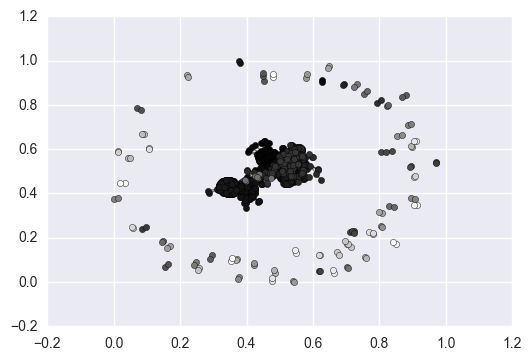

In [39]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
    df.loc[len(df)] = [com, len(list_nodes)]

nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

Let us analyze the two main communities

In [40]:
df.sort(columns='counting',ascending=False).head(2)

C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


com  counting
6  6.0     272.0
0  0.0     243.0

In [41]:
group_1 = [nodes for nodes in partition.keys()
                                if partition[nodes] == 6]
group_2= [nodes for nodes in partition.keys()
                                if partition[nodes] == 0]

In [44]:
group_1_text=emails[emails['ExtractedFrom'].isin(group_1)]['ExtractedBodyText'].astype(str)
group_2_text=emails[emails['ExtractedFrom'].isin(group_2)]['ExtractedBodyText'].astype(str)

In [45]:
group_1_text = createTextFromTokens(group_1_text)
group_2_text=createTextFromTokens(group_2_text)

In [46]:
group_1_text_processed=text_proce_pipeline(group_1_text)
group_2_text_processed=text_proce_pipeline(group_2_text)

In [47]:
# Counting the frequencies
group_1_frequencies = Counter(group_1_text_processed)
group_1_sorted=sorted(group_1_frequencies.items(), key=operator.itemgetter(1),reverse=True)

group_2_frequencies = Counter(group_2_text_processed)
group_2_sorted=sorted(group_2_frequencies.items(), key=operator.itemgetter(1),reverse=True)

### Twenty most frequent words in the biggest communities 

In [48]:
group_1_sorted[0:19]

[('call', 182),
 ('pls', 164),
 ('thx', 139),
 ('get', 111),
 ("n't", 106),
 ('know', 105),
 ('let', 100),
 ('see', 99),
 ('also', 93),
 ('talk', 83),
 ('print', 78),
 ('tomorrow', 78),
 ('like', 77),
 ('pis', 77),
 ('would', 75),
 ('ok.', 68),
 ('want', 66),
 ('need', 62),
 ('time', 61)]

In [49]:
group_2_sorted[0:19]

[('state', 317),
 ('department', 174),
 ('would', 163),
 ('u.s.', 159),
 ('secretary', 148),
 ('women', 139),
 ("n't", 135),
 ('people', 132),
 ('house', 130),
 ('one', 127),
 ('states', 124),
 ('united', 123),
 ('clinton', 123),
 ('said', 122),
 ('benghazi', 116),
 ('time', 114),
 ('world', 110),
 ('information', 109),
 ('president', 109)]

### Results 
The two main communities that appear are easy to label. The first is common action verbs and email lexicon (call, thx...), while the second is clearly refering to Clinton's work and interest as Secretary of State, including Obama, Benghazi or Women...